### Import libraries

In [ ]:
!pip install geopandas
!pip install tilemapbase
!pip install xgboost

In [13]:
#If using google drive

from google.colab import drive
drive.mount('/content/drive')
import os 
os.chdir("/content/drive/MyDrive/RegaH4G/Code")

#otherwise with static datas
path_to_data = '../Datas/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from os.path import join
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import geopy.distance
import requests
import openpyxl
# Import models libraries

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import  make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline

import pickle

## First part : Preprocess

### Load the data -> to improve with real-time datas

#### Load Positions

Helipositionsdaten is the file that obtained from the datalake (contains more or less the same informations than ger_avl_log_rega.csv)

In [3]:
#coordinates of all Rega bases we used
bases = [
    {"name": "Rega-Center", "lat": 47.457990, "lon": 8.572991},
    {"name": "Rega_1", "lat": 47.395876, "lon": 8.637898},
    {"name": "Rega_2", "lat": 47.605896, "lon": 7.523330},
    {"name": "Rega_3", "lat": 46.909619, "lon": 7.504851},
    {"name": "Rega_4", "lat": 46.547337, "lon": 6.618223},
    {"name": "Rega_5", "lat": 46.912776, "lon": 9.551239},
    {"name": "Rega_6", "lat": 46.163171, "lon": 8.881034},
    {"name": "Rega_7", "lat": 47.405521, "lon": 9.290079},
    {"name": "Rega_8", "lat": 46.834069, "lon": 8.638286},
    {"name": "Rega_9", "lat": 46.530427, "lon": 9.878443},
    {"name": "Rega_10", "lat": 46.670054, "lon": 7.876414},
    {"name": "Rega_12", "lat": 47.078150, "lon": 9.066240},
    {"name": "Rega_14", "lat": 46.554903, "lon": 7.379185},
    {"name": "Rega_15", "lat": 46.233339, "lon": 6.096148},
    {"name": "Trainingsbasis Grenchen", "lat": 47.181693, "lon": 7.411192}
]
bases_df = pd.DataFrame(bases)
correct_bases = bases_df.name

In [14]:
def load_positions():
      # positions = pd.read_csv('../HeliPositionsdaten.csv')

      header = ["altitude", "avlid", "bearing", "carid", "cdts", "deviceflags", "deviceinfo", 
            "ext_unitattr", "gpstime", "latitude", "loc_x", "loc_y", "location", 
            "longitude", "num_1", "result", "source", "speed", "status", "tr_status",
            "unid", "unitstatus"]

      positions = pd.read_csv(path_to_data + "ger_avl_log_rega.csv", delimiter=';', names=header)

      # To have same column as in helipositiondaten
      heli_header = ["altitude","gpstime", "latitude", "location", "longitude", "num_1", "unid", "unitstatus"]
      positions = positions[heli_header]

      positions['gpstime'] = pd.to_datetime(positions['gpstime']) # transform 2021-04-07T11:10:58.000Z to 2021-04-07 11:10:58+00:00
      positions.sort_values('gpstime', inplace=True) 

      # To select only the correct bases
      positions = positions[positions["unid"].isin(correct_bases)]

      # remove NaNs
      positions.drop(['altitude'], axis=1, inplace=True)
      positions.dropna(inplace=True)

      positions_per_unit = {}
      for unit in positions['unid'].unique():
            unit_positions = positions[positions['unid'] == unit] 
            positions_per_unit[unit] = unit_positions

      return positions,  positions_per_unit

In HeliPositionsDaten, we only have those columns:

 0	unid	latitude	longitude	location	unitstatus	gpstime	num_1

 In ger_avl_log_rega.csv we have:

 header = ["altitude", "avlid", "bearing", "carid", "cdts", "deviceflags", "deviceinfo", 
          "ext_unitattr", "gpstime", "latitude", "loc_x", "loc_y", "location", 
          "longitude", "num_1", "result", "source", "speed", "status", "tr_status",
          "unid", "unitstatus"]


#### Load Missions 

In [17]:
def load_missions():
    ''' 
    Here all we kept the important rows and columns according  to what Rega told us 
    Only keep primary missions and good important keywords (drawback : it removes a lot of missions)
    To-Do the same preprocessing with real-time data
    '''
    #missions = pd.read_csv("../Dispatch.csv")
    missions = pd.read_csv(path_to_data + "azure_datalake_dispatch.csv")
    missions = missions.set_index("Einsatznummer_ELS")

    #select only primary missions
    missions = missions[missions['Prim_Sek'] == "Primär"]

    # keep only the important columns
    columns_todrop = ["Einsatznummer_SAP","Einsatzstichwort_Beschreibung", "Prim_Sek", "Einsatzort", "LV95_X", "LV95_Y", "Zielort", "Zielort_LV95_X", "Zielort_LV95_Y", "SG_144", "Zielort_WGS84_Latitude", "Zielort_WGS84_Longitude", "Ankunft_Zielort"]        
    missions.drop(columns = columns_todrop, axis=1, inplace=True)

    # only select good_types of "Einsatzstichwort" (premiere colonne -> mot verts)
    good_types = ["SPSP", "ARBA", "UNVE", "UNER", "SPSC", "ARLA", "ARFO", "SPRE", "LAGA", "LAGA", "GLBA", "SPTA", "LAUN", "SPCA", "FLRE", "SPBA", "GLUN", "SPLA", "UNWA", "FLZI", "BESP", "HOHL", "VEBA", "LAVE", "UNIN", "EVSE", "SPMO", "SPSW", "FLMI", "EVMA", "GLKA"]
    missions = missions[missions['Einsatzstichwort'].isin(good_types)]

    missions = missions[missions["Einsatzmittel"].isin(correct_bases)]

    missions = missions[~missions['Einsatzmittel'].isna()]
    missions['Alarmeingang'] = pd.to_datetime(missions['Alarmeingang'])
    
    return missions

not used: Zielort_WGS84_Latitude, Zielort_WGS84_Longitude, Ankunft_Zielort -> deleted 

Helikopter_alarmiert: not used should I delete it?

Used in get last_known_time: Abflug_Einsatzort, Ankunft_Einsatzort, Helikopter_alarmiert

### Preprocessing

#### Add liftoff positions and time
(liftoff positions = the first position detected just after "start_time" = alarm time)

In [18]:
def get_location_after(start_time: datetime, callsign: str):
    x = positions[positions['unid'] == callsign]
    # Select only positions after start time
    x = x[x['gpstime'] >= start_time]
    # Select positions not later than 30 minutes
    x = x[x['gpstime'] <= (start_time + timedelta(minutes=30))]
    if x.shape[0] <= 0:
        # return default base position 
        return bases[callsign]
        # raise Exception("Default position")
        # TODO: return default base position
    else:
        # Select the oldest position
        idx = x['gpstime'].idxmin() # Return index of first occurrence of minimum over the rows
        return x.loc[idx, 'gpstime'], (x.loc[idx, 'latitude'], x.loc[idx, 'longitude'])

In [19]:
def add_liftoff_positions(missions):
    liftoff_times, start_lat, start_lng = [], [], []
    total_cnt, ok_cnt = 0, 0
    for idx, row in tqdm(missions.iterrows()):
        start_t = row['Alarmeingang']
        #start_t = row['Helikopter_alarmiert']
        total_cnt += 1
        try:
            callsign = row['Einsatzmittel']
            ref_t, (lat, lng) = get_location_after(start_t, callsign)
            liftoff_times.append(ref_t)
            start_lat.append(lat)
            start_lng.append(lng)
            ok_cnt += 1
        except:
            liftoff_times.append(None)
            start_lat.append(None)
            start_lng.append(None)
    missions['liftoff_time'] = liftoff_times
    missions['liftoff_lat'] = start_lat
    missions['liftoff_lng'] = start_lng
    print(f"Added {ok_cnt} / {total_cnt} liftoff times and positions")
    return missions

#### Add "arrival" times 
times when we arrive in a 2km region of the patients (time_patient = t1a), after this 2km region, time become noisy and unpredictible

In [20]:
# get last time register for this mission
def get_last_known_time(mission):
    if mission['Abschlusszeit']:
        return mission['Abschlusszeit']
    elif mission['Abflug_Einsatzort']:
        return mission['Abflug_Einsatzort']
    elif mission['Ankunft_Einsatzort']:
        return mission['Ankunft_Einsatzort']
    return mission['liftoff_time'] - pd.Timedelta("1s")  # will be dropped

In [21]:
# get the positions that interest us before a certain time
def filter_positions_for_mission(mission, which='t1+'):
    if which not in ['t1', 't1+', 'all']: raise Exception("Not implemented")

    unit = mission['Einsatzmittel']
    if unit not in positions_per_unit:
        print("Unknown unit", unit)
        return positions[positions['latitude'] == 129048240]  # TODO: raise or whatever
    
    #cols = ['carid', 'unid', 'latitude', 'longitude', 'gpstime', 'bearing']
    cols = ['unid', 'latitude', 'longitude', 'gpstime']
    mission_positions = positions_per_unit[unit]
    mission_positions = mission_positions[cols]
    # mission_positions = mission_positions[mission_positions['unid'] == mission['Einsatzmittel']]
    mission_positions = mission_positions[mission_positions['gpstime'] >= mission['liftoff_time']]
    if which == 't1':
        # delta = timedelta(hours=1)
        mission_positions = mission_positions[mission_positions['gpstime'] <= mission['Ankunft_Einsatzort']]
    elif which == 't1+':
        mission_positions = mission_positions[mission_positions['gpstime'] <= mission['Abflug_Einsatzort']]
    elif which == 'all':
        end_time = get_last_known_time(mission)
        mission_positions = mission_positions[mission_positions['gpstime'] <= end_time]
    return mission_positions

In [22]:
# return the first positions that is in less than a 2km radius of the missios locations
def get_point_nearby(positions, landing_point, threshold_km=2, outside=False):
    # pos = filter_positions_for_mission(mission, which='all')
    for idx, row in positions.iterrows():
        lat, lng = row['latitude'], row['longitude']
        if (geopy.distance.distance(landing_point, (lat, lng)).km < threshold_km) != outside:
            return (idx, row['gpstime'], lat, lng)
    return None

- WGS84_Latitude: latitude of mission location (WGS-84 coordinate system)
- WGS84_Longitude: longitude of mission location (WGS-84 coordinate system)

In [23]:
def get_arrival_at_patient(mission, positions):
    landing_point = (mission['WGS84_Latitude'], mission['WGS84_Longitude'])
    return get_point_nearby(positions, landing_point)

In [24]:
def add_times_patient(missions):
    times_t1a, times_t1b, times_t1c, lats, lngs = [], [], [], [], []
    for idx, row in tqdm(missions.iterrows()):
        time_start = row['liftoff_time']
        
        positions = filter_positions_for_mission(mission=row, which='all')
        # estimate landing @ patient location
        landing_patient = get_arrival_at_patient(mission=row, positions=positions)
        if landing_patient is not None:
            (idx, gpstime, latitude, longitude) = landing_patient
            gpstime = pd.to_datetime(gpstime)
            time_start = pd.to_datetime(time_start)
            time_t1a = pd.to_timedelta(gpstime - time_start).total_seconds()
            times_t1a.append(time_t1a); lats.append(latitude); lngs.append(longitude) 
        else:
            times_t1a.append(None); lats.append(np.nan); lngs.append(np.nan)
    missions['time_patient'] = times_t1a
    missions['patient_arrival_lat'] = lats
    missions['patient_arrival_lng'] = lngs
    # missions.dropna(inplace=True)
    return missions

#### Extract features : elevation, distance and weather

In [25]:
# Colin function to get elevetion data
def getElevationData(lat_start, lon_start, lat_end, lon_end):
    """Get elevation data of direct path between two locations

    Arguments:
    lat_start -- Latitude of starting position
    lon_start -- Longitude of starting position
    lat_end -- Latitude of ending position
    lon_end -- Longitude of ending position
    
    Returns:
    Dictionary with
        climb -- total climb distance (meters)
        descent -- total descent distance (meters)
        vert_travel_dist -- total vertical travel distance (meters)
    """
    api_baseURL = "https://api.elevationapi.com/api/Elevation/line"
    requestURL = f"{api_baseURL}/{lat_start},{lon_start}/{lat_end},{lon_end}"
    
    request = requests.get(requestURL)
    request.raise_for_status() # Throws exception if API call was not successful
    
    response_json = request.json()
    
    result = dict()
    result["climb"] = response_json["metrics"]["climb"]
    result["descent"] = abs(response_json["metrics"]["descent"])
    result["vert_travel_dist"] = result["climb"] + result["descent"]
    
    return result

In [26]:
def extract_flight_features(missions, show_results=False):
    distance_ratios = []
    all_ratios = []
    ok, thrown = 0, 0

    for idx, mission in missions.iterrows():
        
        positions = filter_positions_for_mission(mission, which='all')
        landing_patient = get_arrival_at_patient(mission, positions)
        if landing_patient is None:
            all_ratios.append(None)
            continue
        (idx, gpstime, patient_lat, patient_lng) = landing_patient

        # calculate total distance in all line segments
        total_km = 0.
        first_position = None
        prev_position = None
        for j, pos in positions[positions['gpstime'] <= gpstime].iterrows():
            if prev_position is None:
                first_position = prev_position = pos
            else:
                last_coords = (prev_position['latitude'], prev_position['longitude'])
                pos_coords = (pos['latitude'], pos['longitude'])
                dist = geopy.distance.distance(last_coords, pos_coords)
                total_km += dist.km
                prev_position = pos
        
        # calculate air distance
        takeoff_lat, takeoff_lng = first_position['latitude'], first_position['longitude']
        straight_km = geopy.distance.distance((takeoff_lat, takeoff_lng), (patient_lat, patient_lng)).km
        
        # compare distances
        dist_ratio = total_km / (straight_km + 0.000001)
        if dist_ratio > 2 or dist_ratio < 0.9:
            # plot_trajectory(mission)
            thrown += 1
            all_ratios.append(None)
            continue
        ok += 1
        all_ratios.append(dist_ratio)
        distance_ratios.append(dist_ratio)

    # TODO: calculate overall direction -> we think it's does he go to nord, est, west?
    # TODO: calculate wind speed and direction
    
    print(f"Distance ratio max: {np.max(distance_ratios)} min: {np.min(distance_ratios)} mean: {np.mean(distance_ratios)}")
    print(f"OK: {ok} Thrown away (too long): {thrown}")
    if show_results:
        plt.hist(distance_ratios, bins=100)
        plt.title(f"Distance ratio ({thrown} outliers removed)")
        plt.xlabel("Flight distance / straight line distance [km]")
        plt.ylabel("Mission count")
        plt.show()  # TODO: maybe throw zeros too?

    missions['distance_ratio'] = all_ratios

    # Add elevation data
    missions.dropna(inplace=True)               
    #/!\ Remove a lot of rows ! Dig deeper and potentially think about fillna() instead of removing them

    climb_data = []
    descent_data = []
    vert_travel_dist_data = []

    for index, row in missions.iterrows():
        res = getElevationData(row["liftoff_lat"],
                        row["liftoff_lng"],
                        row["WGS84_Latitude"],
                        row["WGS84_Longitude"])
        climb_data.append(res["climb"])
        descent_data.append(res["descent"])
        vert_travel_dist_data.append(res["vert_travel_dist"])
    missions["climb"] = climb_data
    missions["descent"] = descent_data
    missions["vert_travel_dist"] = vert_travel_dist_data

    #Add Weather data
    #Todo : Improve this data, not really useful in our case
    #The csv file comes from a separate notebook "get_weather_data.ipynb". 
    #The way to retrieve weather data can also be improved since, we had to wait 
    #15s after some queries not to overload the website and then combine all the text files into one csv file.
    
    weather_data = pd.read_csv(path_to_data + "weather_info.csv", sep=";")
    missions = missions.merge(weather_data, left_on="Einsatznummer_ELS", right_on="Einsatznummer_ELS")

    return missions

#### Pipeline to load data

In [27]:
path_to_data = '../Datas/'

positions, positions_per_unit= load_positions()
missions = load_missions()
print("Missions loaded ... ")
missions = add_liftoff_positions(missions)
print("Added liftoff positions")
missions = add_times_patient(missions)
print("Added Time to patient")
missions = extract_flight_features(missions)
print("Features extracted... ")

Missions loaded ... 


0it [00:00, ?it/s]

Added 699 / 1550 liftoff times and positions
Added liftoff positions


0it [00:00, ?it/s]

Added Time to patient
Distance ratio max: 1.8940998061123353 min: 0.9999983075416827 mean: 1.0654084478122312
OK: 618 Thrown away (too long): 26
Features extracted... 


#### Save postions and missions dataframes

In [ ]:
# TODO -> delete duplicates before saving df
#duplicate for Einsatznummer : E200822078 and E191229030 
missions = missions[~missions.index.duplicated(keep='first')]

#This allow us to do all the preprocessing only once
#Can be different using real-time data

missions.to_csv(path_to_data + 'missions_df.csv')
positions.to_csv(path_to_data +'positions_df.csv')

## Second Part : Learning

### Import data and libraries

In [ ]:
missions = pd.read_csv(path_to_data + "missions_df.csv")
positions = pd.read_csv(path_to_data + "positions_df.csv")

positions.set_index('num_1', inplace= True)
positions.drop(columns="Unnamed: 0", axis=0, inplace= True)

### Create dataframes for the model

In [ ]:
def get_target(data):
    '''
    Returns the column 'time_patient' from the dataframe
    This is the variable to optimize for the model 
    '''
    y = data['time_patient']
    y = y.values.flatten()
    return y

In [ ]:
def build_df(data):
    '''
    Input : data containing the following features (to remove here if non necessary) : 
            ['liftoff_lat', 'WGS84_Latitude', 'liftoff_lng', 'WGS84_Longitude',
            'climb', "descent","vert_travel_dist", "visibility", "heavy_clouds"]
    Output: Dataframe to use as an input for the model
    '''
    #Distance features
    lat_delta = (data['liftoff_lat'] - data['WGS84_Latitude']).abs()
    lng_delta = (data['liftoff_lng'] - data['WGS84_Longitude']).abs()

    X_new = pd.concat((lat_delta, lng_delta), axis=1)

    X_new.rename({0: "lat_delta", 1: "lng_delta"}, inplace=True, axis=1)

    X_new['distance'] = data.apply(
        lambda r: geopy.distance.distance(
            (r['liftoff_lat'], r['liftoff_lng']),
            (r['WGS84_Latitude'], r['WGS84_Longitude'])).km, axis = 1 )

    #Add elevation features
    X_new["climb"] = data["climb"] 
    X_new["descent"] = data["descent"]
    X_new["vert_travel_dist"] = data["vert_travel_dist"]
    
    #Add weather features 
    X_new["visibility"] = data["visibility"]
    X_new["heavy_clouds"] = data["heavy_clouds"]
    return X_new

In [ ]:
X = build_df(missions)
y = get_target(missions)

### Evaluation of the model

In [ ]:
def validation_2mn(y_real, y_pred):
    '''
    A prediction is considered as correct if the error between it and the real 
    time is less than 2mn.
    Threshold defined with Rega.
    '''
    correct = 0
    for i in range(len(y_real)): 
        if np.abs(y_real[i] - y_pred[i]) <= 120.0 : #seconds
            correct += 1
    score = correct/len(y_real)
    return score

In [ ]:
def physical_model(X, speed):
    '''
    Basic model, approximation of the human prediction.
    '''
    y_pred = X['distance']/speed
    return y_pred*3600

In [ ]:
def visualize(err, err_phys):
      err_phys = pd.Series(err_phys[err_phys<700])

      fig, (ax1, ax2) = plt.subplots(2,1, figsize = (16, 6))

      err_phys.plot.hist(grid=True, bins=60, rwidth=0.9,
                        color='#E8CB90', ax = ax1, label="predictions")

      threshold_time = 120

      ax1.vlines(threshold_time, 0, 20, linestyles='dashed', colors='r', label="2 min. threshold")
      ax1.set_title('Physical model')
      ax1.legend()
      ax1.set_ylabel('Number of missions')
      plt.grid(axis='y', alpha=0.75)

      #plot ML model error distribution
      err = pd.Series(err[err<700])

      err.plot.hist(grid=True, bins=60, rwidth=0.9,
                        color='#607c8e', ax = ax2, label="predictions")
      threshold_time = 120
      ax2.vlines(threshold_time, 0, 20, linestyles='dashed', colors='r', label="2 min. threshold")
      ax2.set_title('ML model')
      ax2.legend()
      ax2.set_ylabel('Number of missions')
      plt.xlabel('Time [s]')
      plt.grid(axis='y', alpha=0.75)

      plt.suptitle('Error distribution for the model')
      #plt.savefig("../Datas/error_dist.png", dpi=300)
      plt.show()

In [ ]:
def eval_model(model, X, y, plot=False):
    v = X['distance']*3600/y
    speed = v.mean()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=4)
    
    #prediction using Physical model 
    y_train_pred_phys = physical_model(X_train, speed)
    y_test_pred_phys = physical_model(X_test, speed)

    #Score of the model
    print("Physical model : 2mn validation train : %.3f" % 
        validation_2mn(y_train, y_train_pred_phys.values))
    print("Physical model : 2mn validation test: %.3f" %
        validation_2mn(y_test, y_test_pred_phys.values))

    #prediction using : ML models 
    model.fit(X_train, y_train)
    #Predict values
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    #Score of the model
    print("2mn validation train: %.3f" %validation_2mn(y_train, y_train_pred))
    print("2mn validation test: %.3f" %validation_2mn(y_test, y_test_pred))

    err = np.sort(np.abs(y_test - y_test_pred))
    err_phys = np.sort(np.abs(y_test - y_test_pred_phys))
    if plot:
        visualize(err, err_phys)

In [ ]:
def cross_validation(model, X, y):
    n_cv = 5
    cv_results = cross_validate(model, X, y, cv=n_cv, scoring=make_scorer(validation_2mn))
    mean_score = np.mean(cv_results["test_score"])
    print(f"Mean accuracy over {n_cv} runs: {mean_score}")
    # return cv_results

In [ ]:
# Cross validation

best_features = ["lat_delta", "lng_delta", "climb", "descent", "vert_travel_dist", "distance"]

#Choose model
print(">>>>>>Gradient Boost Regressor<<<<<<<<")
reg = GradientBoostingRegressor()
cross_validation(reg, X[best_features], y)

print("\n>>>>>Lasso<<<<<<<<")
lasso = Lasso(alpha= 0.65, normalize= False)
cross_validation(lasso, X[best_features], y)

print("\n>>>>>>Ridge<<<<<<<<")
ridge = Ridge(alpha= 0.6, normalize = True) 
cross_validation(ridge, X[best_features], y)

print("\n>>>>>>xbgbreg<<<<<<<<")
xgbreg = GradientBoostingRegressor()
cross_validation(xgbreg, X[best_features], y)

print("\n>>>>>>lgbreg<<<<<<<<")
lgbreg = LGBMRegressor()
cross_validation(lgbreg, X[best_features], y)

Best model we found


>>>>>Lasso<<<<<<<<
Physical model : 2mn validation train : 0.632
Physical model : 2mn validation test: 0.660
2mn validation train: 0.831
2mn validation test: 0.860


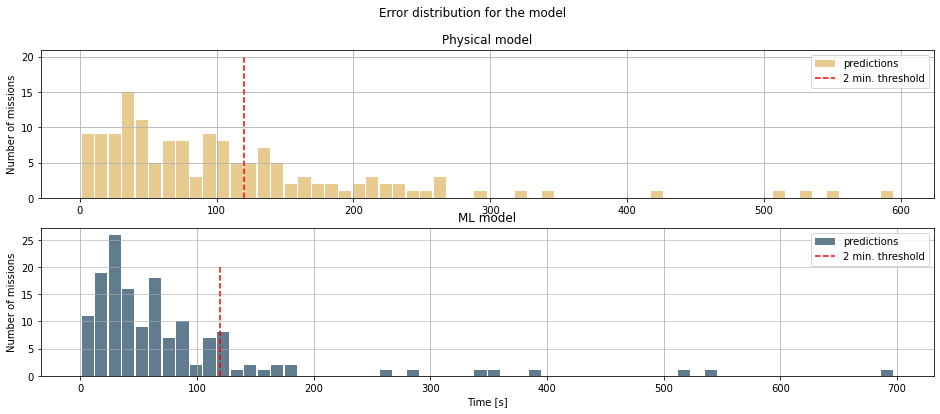

In [ ]:
best_model = make_pipeline(StandardScaler(with_mean=False), Lasso(alpha= 0.55, normalize= True))
best_features = ["lat_delta", "lng_delta", "climb", "descent", "vert_travel_dist", "distance"]
#best_features = ["lat_delta", "lng_delta", "distance"]

eval_model(best_model, X[best_features], y, True)

Save the best model for the API in a pickle file, after fitting it with the whole dataset

In [ ]:
best_features = ["lat_delta", "lng_delta", "climb", "descent", "vert_travel_dist", "distance"]
best_model = Lasso(alpha= 0.65, normalize= False)
best_model.fit(X[best_features], y)
with open(path_to_data + "best_model.pickle", "wb") as file:
    pickle.dump(best_model, file)

### Dispatch decision using this model

In [ ]:
bases = [
    #{"name": "Rega-Center", "lat": 47.457990, "lon": 8.572991},
    {"name": "Rega_1", "lat": 47.395876, "lon": 8.637898},
    {"name": "Rega_2", "lat": 47.605896, "lon": 7.523330},
    {"name": "Rega_3", "lat": 46.909619, "lon": 7.504851},
    {"name": "Rega_4", "lat": 46.547337, "lon": 6.618223},
    {"name": "Rega_5", "lat": 46.912776, "lon": 9.551239},
    {"name": "Rega_6", "lat": 46.163171, "lon": 8.881034},
    {"name": "Rega_7", "lat": 47.405521, "lon": 9.290079},
    {"name": "Rega_8", "lat": 46.834069, "lon": 8.638286},
    {"name": "Rega_9", "lat": 46.530427, "lon": 9.878443},
    {"name": "Rega_10", "lat": 46.670054, "lon": 7.876414},
    {"name": "Rega_12", "lat": 47.078150, "lon": 9.066240},
    {"name": "Rega_14", "lat": 46.554903, "lon": 7.379185},
    {"name": "Rega_15", "lat": 46.233339, "lon": 6.096148},
    #{"name": "Trainingsbasis Grenchen", "lat": 47.181693, "lon": 7.411192}
]
bases_df = pd.DataFrame(bases)

correct_bases = bases_df.name

missions = pd.read_csv(path_to_data + "missions_df.csv")


In [ ]:
# Also done in the code for the API, might not be useful here (or just for information)
def choose_base(mission, bases):
    with open(path_to_data + "best_model.pickle", "rb") as file:
        model = pickle.load(file) 

    preds = pd.DataFrame()

    for base in bases:   
        new_df = pd.DataFrame()
        new_df['WGS84_Latitude'] = mission.WGS84_Latitude 
        new_df['WGS84_Longitude'] = mission.WGS84_Longitude
        base_row = bases_df[bases_df["name"] == base]
        new_df['liftoff_lat'] = np.array(base_row.lat)
        new_df['liftoff_lng'] = np.array(base_row.lon)
        new_df['climb'] = mission.climb
        new_df['descent'] = mission.descent
        new_df['vert_travel_dist'] = mission.vert_travel_dist
        new_df['visibility'] = mission.visibility
        new_df['heavy_clouds'] = mission.heavy_clouds

        X_test = build_df(new_df) 
        X_test = X_test.drop(["visibility", "heavy_clouds"], axis=1)
        pred = model.predict(X_test)
        new_pred = pd.DataFrame({"name": base, "time_pred": pred})
        preds = pd.concat((preds, new_pred), axis=0)

    preds["Bases"] = range(0, len(correct_bases))
    preds.set_index("Bases", inplace = True)

    idx = np.argmin(preds['time_pred'])
    sorted = preds.sort_values(by = "time_pred")
    three_lowest_names = sorted[:3]

    return preds, preds.iloc[idx]["name"], three_lowest_names #name of the base to call 

In [ ]:
choose_base(missions.head(1), correct_bases)